# Inital Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Local application/library specific imports
import importlib
import sys
import os
base_path = 'C:/Users/Henri/Emilie/Thesis'
sys.path.append(base_path + '/code')
import project_functions as pf
importlib.reload(pf) # Reloading the local module 
from matplotlib.colors import LinearSegmentedColormap

# Reloading the local module 
importlib.reload(pf)

base_path = 'C:/Users/Henri/Emilie/Thesis'

In [2]:
# Load train data
df_train = pd.read_csv(base_path + '/data/trainZR_v3_31.csv')

# Remove low quality data
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train = df_train[df_train['timestamp'].dt.minute % 10 == 0]

# Convert R to mm/h
df_train['R_mm_per_h'] = df_train['R'] * 60

## Part 1: Radar Reflectivity and Rain Intensity Relationship

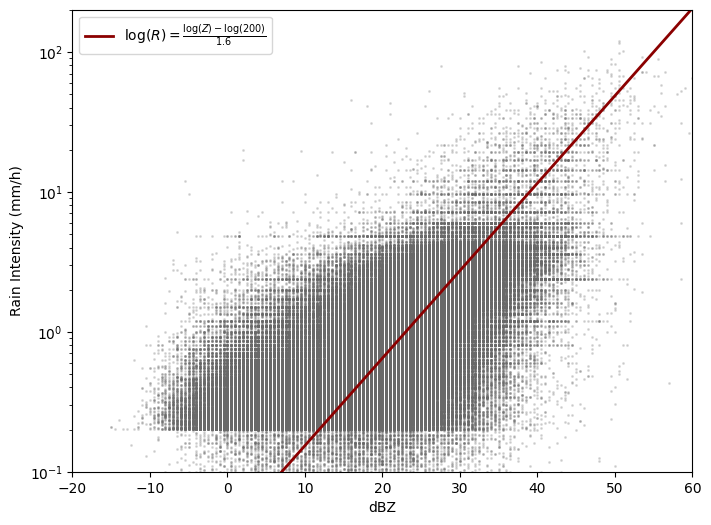

In [13]:
# Plot the relationship between Z and R for each bin in one plot with different colors
plt.figure(figsize=(8, 6))

# Plot the scatter points
plt.scatter(df_train['dBZ'], df_train['R_mm_per_h'], color='dimgray', alpha=0.2, marker='.', s = 5)

# Plot the line corresponding to log(R) = (log(Z) - log(200))/1.6
Z_values = np.linspace(-20, 60, 500)  
Z_linear = 10**(Z_values / 10)  
R_values = np.exp((np.log(Z_linear) - np.log(200)) / 1.6) 

plt.plot(Z_values, R_values, color='darkred', linestyle='-', lw=2, label=r'$\log(R) = \frac{\log(Z) - \log(200)}{1.6}$')

plt.xlabel('dBZ')
plt.ylabel('Rain Intensity (mm/h)')
plt.xscale('linear')  
plt.yscale('log')  # 
plt.xlim(-20, 60)
plt.ylim(0.1, 200)  
plt.legend()
#plt.axhline(y=0.2, color='k', linestyle='--', linewidth=1)
#plt.grid()
plt.savefig('scatter_with_MP.png', format='png', dpi=300)
plt.show()


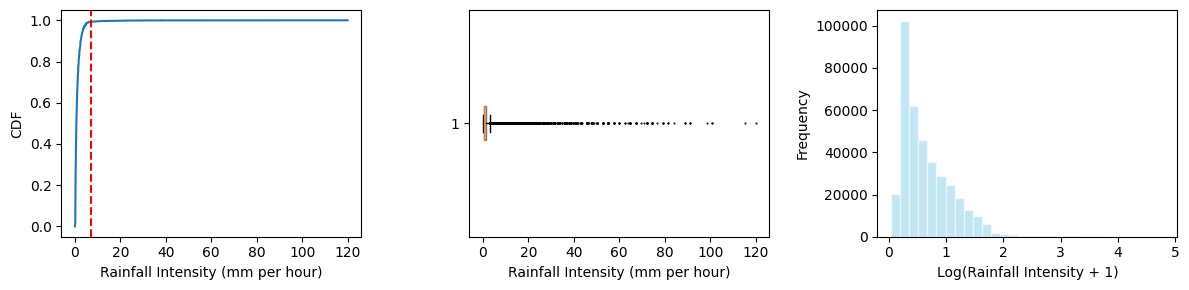

In [14]:
pos_idx = (df_train['R_mm_per_h'] != 0) & (~np.isnan(df_train['R_mm_per_h']))

# Assuming df_train['R_mm_per_h'] and pos_idx are correctly defined
log_data = np.log1p(df_train['R_mm_per_h'].loc[pos_idx])  # log1p is used to handle zero values safely
filtered_data = df_train['R_mm_per_h'].loc[pos_idx]

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(12,3))  # 1 row, 3 columns, adjusted figure size

# Plot 1: Log-Transformed Histogram
axs[2].hist(log_data, bins=30, color='skyblue', alpha=0.5, edgecolor='white')
#axs[0].set_title('Log-Transformed Histogram of Rainfall Intensity')
axs[2].set_xlabel('Log(Rainfall Intensity + 1)')
axs[2].set_ylabel('Frequency')

# Plot 2: Box Plot
axs[1].boxplot(filtered_data, vert=False, patch_artist=True, 
               flierprops={'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 1},
               boxprops=dict(facecolor='skyblue', alpha=0.5))
#axs[1].set_title('Box Plot of Rainfall Intensity')
axs[1].set_xlabel('Rainfall Intensity (mm per hour)')

# Plot 3: Cumulative Distribution Function (CDF)
data_sorted = np.sort(filtered_data)
cdf = np.arange(len(data_sorted)) / float(len(data_sorted) - 1)
axs[0].plot(data_sorted, cdf)
#axs[2].set_title('Cumulative Distribution Function of Rainfall Intensity')
axs[0].set_xlabel('Rainfall Intensity (mm per hour)')
axs[0].set_ylabel('CDF')
axs[0].axvline(x=7, color='r', linestyle='--')
#axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
fig.savefig('rainfall_analysis.png', dpi=300)
plt.show()


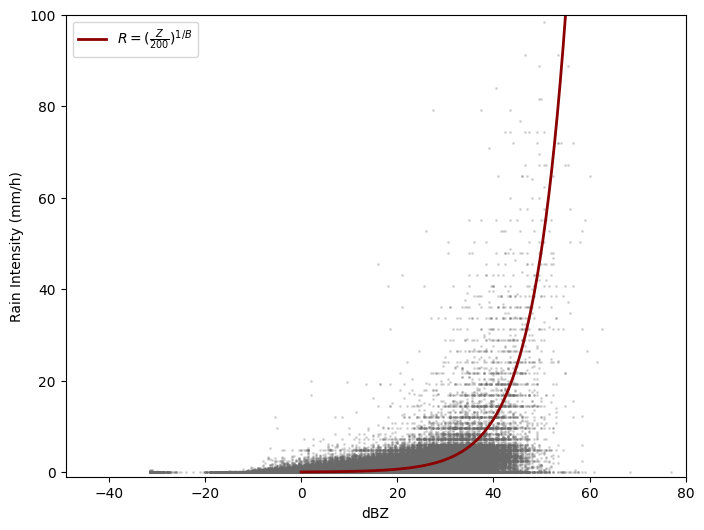

In [19]:
# Plot the relationship between Z and R for each bin in one plot with different colors
plt.figure(figsize=(8, 6))

# Plot the scatter points
plt.scatter(df_train['dBZ'], df_train['R_mm_per_h'], color='dimgray', alpha=0.2, marker='.', s = 5)

# Plot the line corresponding to log(R) = (log(Z) - log(200))/1.6
#Z_values = np.linspace(0, 100000, 500)  
#R_values = (Z_values/200)**(1/1.6)
dBZ_values = np.linspace(0, 100, 500)  
R_values = pf.dbz_to_R_marshall_palmer(dBZ_values)


plt.plot(dBZ_values, R_values, color='darkred', linestyle='-', lw=2, label=r'$R=(\frac{Z}{200})^{1/B}$')

plt.xlabel('dBZ')
plt.ylabel('Rain Intensity (mm/h)')
#plt.xscale('log')  
#plt.yscale('log')  # 
plt.xlim(-49, 80)
plt.ylim(-1, 100)  
plt.legend()
#plt.axhline(y=0.2, color='k', linestyle='--', linewidth=1)
#plt.grid()
plt.savefig('scatter_with_MP_RZ.png', format='png', dpi=300)
plt.show()


## Part 2: Analysis of Rain Intensity Distribution

In [3]:
df_test = pd.read_csv(base_path + f'/data/testZR_v3_63.csv')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]
df_test['R_mm_per_h'] = df_test['R'] * 60

In [7]:
df_val = pd.read_csv(base_path + f'/data/valZR_v3_63.csv')
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_val = df_val[df_val['timestamp'].dt.minute % 10 == 0]
df_val['R_mm_per_h'] = df_val['R'] * 60

In [35]:
# Define bins and labels
bins = [0, 0.5, 2, 6, 10, 18, 30, np.inf]
labels = ['No rain \n(<0.5 mm/h)', 'Weak rain\n(0.5-2 mm/h)', 'Moderate rain\n(2-6 mm/h)', 
              'Heavy rain\n(6-10 mm/h)', 'Very heavy rain\n(10-18 mm/h)', 'Shower\n(18-30 mm/h)', 'Cloudburst\n(>30 mm/h)']

# Calculate Z and dBZ using the Marshall-Palmer equation
A = 200
B = 1.6
Z = A * np.array(bins) ** B
dBZ = 10 * np.log10(Z)

# Print the results with two decimal places
for label, z_value, dbz_value in zip(labels, Z, dBZ):
    print(f'Z = {z_value:.2f}, dBZ = {dbz_value:.2f}')


Z = 0.00, dBZ = -inf
Z = 65.98, dBZ = 18.19
Z = 606.29, dBZ = 27.83
Z = 3516.19, dBZ = 35.46
Z = 7962.14, dBZ = 39.01
Z = 20392.29, dBZ = 43.09
Z = 46176.82, dBZ = 46.64


C:\Users\Henri\AppData\Local\Temp\ipykernel_8464\1693844384.py:10: RuntimeWarning: divide by zero encountered in log10
  dBZ = 10 * np.log10(Z)


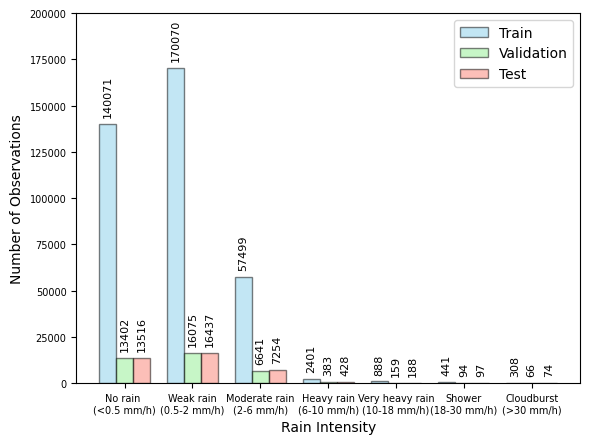

In [40]:
# Bin the data
df_train['rain_bin'] = pd.cut(df_train['R_mm_per_h'], bins=bins, labels=labels)
df_val['rain_bin'] = pd.cut(df_val['R_mm_per_h'], bins=bins, labels=labels)
df_test['rain_bin'] = pd.cut(df_test['R_mm_per_h'], bins=bins, labels=labels)

# Calculate the distribution
bin_counts_train = df_train['rain_bin'].value_counts().reindex(labels, fill_value=0)
bin_counts_val = df_val['rain_bin'].value_counts().reindex(labels, fill_value=0)
bin_counts_test = df_test['rain_bin'].value_counts().reindex(labels, fill_value=0)

# Plot the distribution
fig, ax = plt.subplots(figsize=(6, 4.55))

bar_width = 0.25
index = np.arange(len(labels))

bars_train = ax.bar(index - bar_width, bin_counts_train, bar_width, color='skyblue', edgecolor='black', alpha=0.5, label='Train')
bars_val = ax.bar(index, bin_counts_val, bar_width, color='lightgreen', edgecolor='black', alpha=0.5, label='Validation')
bars_test = ax.bar(index + bar_width, bin_counts_test, bar_width, color='salmon', edgecolor='black', alpha=0.5, label='Test')

# Add count labels on top of the bars
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Rain Intensity')
plt.ylabel('Number of Observations')
plt.xticks(index, labels, rotation=0, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.legend()
plt.ylim(0, 200000)

plt.tight_layout()

# Save and show the plot
plt.savefig('rain_intensity_distribution.png', format='png', dpi=300)
plt.show()

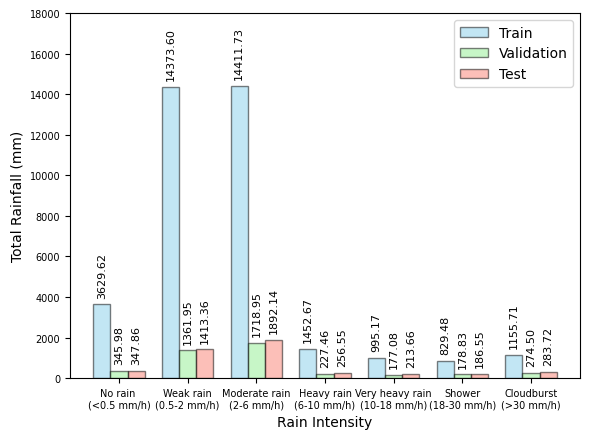

In [42]:
# Bin the data
df_train['rain_bin'] = pd.cut(df_train['R_mm_per_h'], bins=bins, labels=labels)
df_val['rain_bin'] = pd.cut(df_val['R_mm_per_h'], bins=bins, labels=labels)
df_test['rain_bin'] = pd.cut(df_test['R_mm_per_h'], bins=bins, labels=labels)

# Calculate total rainfall in each bin (in mm)
df_train['total_rain_mm'] = df_train['R_mm_per_h'] * (5 / 60)  # Convert to mm per 5 minutes
df_val['total_rain_mm'] = df_val['R_mm_per_h'] * (5 / 60)  # Convert to mm per 5 minutes
df_test['total_rain_mm'] = df_test['R_mm_per_h'] * (5 / 60)  # Convert to mm per 5 minutes

# Sum the total rainfall in each bin
total_rainfall_train = df_train.groupby('rain_bin')['total_rain_mm'].sum().reindex(labels, fill_value=0)
total_rainfall_val = df_val.groupby('rain_bin')['total_rain_mm'].sum().reindex(labels, fill_value=0)
total_rainfall_test = df_test.groupby('rain_bin')['total_rain_mm'].sum().reindex(labels, fill_value=0)

plt.figure(figsize=(6, 4.5))

# Plot the total rainfall
bar_width = 0.25
index = np.arange(len(labels))

bars_train = plt.bar(index - bar_width, total_rainfall_train, bar_width, color='skyblue', edgecolor='black', alpha=0.5, label='Train')
bars_val = plt.bar(index, total_rainfall_val, bar_width, color='lightgreen', edgecolor='black', alpha=0.5, label='Validation')
bars_test = plt.bar(index + bar_width, total_rainfall_test, bar_width, color='salmon', edgecolor='black', alpha=0.5, label='Test')

# Add total rainfall labels on top of the bars
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Rain Intensity')
plt.ylabel('Total Rainfall (mm)')
plt.xticks(index, labels, rotation=0, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.ylim(0, 18000)
plt.legend()

plt.tight_layout()
plt.savefig('rain_intensity_distribution_aggregated.png', format='png', dpi=300)
plt.show()


In [27]:
# Define a function to compute the percentages
def compute_percentages(df, column):
    total_count = len(df)
    positive_count = df[column].gt(0).sum()  # Count where R > 0
    zero_count = df[column].eq(0).sum()  # Count where R = 0
    nan_inf_count = df[column].isna().sum().sum()  # Count where R is NaN or Inf
    
    positive_percentage = (positive_count / total_count) * 100
    zero_percentage = (zero_count / total_count) * 100
    nan_inf_percentage = (nan_inf_count / total_count) * 100
    
    return positive_percentage, zero_percentage, nan_inf_percentage

# Compute the percentages for both datasets
train_percentages = compute_percentages(df_train, 'R_mm_per_h')
test_percentages = compute_percentages(df_test, 'R_mm_per_h')

# Create a table
table = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'R > 0 (%)': [train_percentages[0], test_percentages[0]],
    'R = 0 (%)': [train_percentages[1], test_percentages[1]],
    'R is NaN (%)': [train_percentages[2], test_percentages[2]]
})

# Print the table
print(table)


     Set  R > 0 (%)  R = 0 (%)  R is NaN (%)
0  Train   5.071236  93.971626      0.957138
1   Test   6.056790  92.307778      1.635432


## Part 3 Analysis of Temporal Alignment of Datasets

In [9]:
# Load train data
df_train = pd.read_csv(base_path + '/data/trainZR_v3_31.csv')

# Remove low quality data
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
#df_train = df_train[df_train['timestamp'].dt.minute % 10 == 0]

# Convert R to mm/h
df_train['R_mm_per_h'] = df_train['R'] * 60

In [10]:
from tqdm import tqdm

# Define the cloudburst threshold
threshold = 6  # mm/h
time_window = pd.Timedelta(minutes=30)  # Define time window around the event

# Convert timestamp column to datetime if not already done
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# Remove observations where R or Z is NaN
df_train = df_train.dropna(subset=['R_mm_per_h', 'Z'])

# Identify cloudburst events and their corresponding stations
events = df_train[df_train['R_mm_per_h'] > threshold]

# Create a relative time range index
time_range = pd.timedelta_range(start='-30T', end='30T', freq='5T')
time_range_minutes = time_range.total_seconds() // 60  # Convert to minutes

# Initialize lists to hold aggregated data
agg_reflectivity_list = []
agg_rain_intensity_list = []

# Function to extract and aggregate time series around each cloudburst event
for index, event in tqdm(events.iterrows(), total=events.shape[0]):
    station_id = event['stationId']
    event_time = event['timestamp']
    
    # Filter the time series for the specific station and time window
    time_series = df_train[(df_train['stationId'] == station_id) &
                           (df_train['timestamp'] >= event_time - time_window) & 
                           (df_train['timestamp'] <= event_time + time_window)].copy()
    
    # Align the time series index to the relative time range
    time_series['relative_time'] = (time_series['timestamp'] - event_time).dt.total_seconds() // 60
    time_series.set_index('relative_time', inplace=True)
    
    # Check for duplicate relative_time values and remove them
    time_series = time_series[~time_series.index.duplicated(keep='first')]
    
    # Reindex to match the relative time range and fill missing values with NaN
    time_series = time_series.reindex(time_range_minutes)
    
    # Add to the list if the time series has the complete range
    if time_series.shape[0] == len(time_range_minutes):
        agg_reflectivity_list.append(time_series['Z'].values)
        agg_rain_intensity_list.append(time_series['R_mm_per_h'].values)

# Convert lists to numpy arrays for aggregation
agg_reflectivity_array = np.array(agg_reflectivity_list)
agg_rain_intensity_array = np.array(agg_rain_intensity_list)

 18%|█▊        | 1454/8036 [01:51<08:23, 13.08it/s]


KeyboardInterrupt: 

In [ ]:
# Plot the averaged time series with separate plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot average reflectivity (Z)
#ax1.set_xlabel('Time Relative to Event (minutes)')
ax1.set_ylabel('Reflectivity (Z)')
ax1.plot(time_range_minutes, np.nanmean(agg_reflectivity_array, axis=0), '.-', label='Average Reflectivity')
ax1.tick_params(axis='y')
ax1.axvline(0, color='k', linestyle='dotted', label='>6mm/h Event')
ax1.legend()
ax1.grid()
#ax1.set_title('Average Reflectivity around Cloudburst Events')

# Plot average rain intensity (R_mm_per_h)
ax2.set_xlabel('Time Relative to Event (minutes)')
ax2.set_ylabel('Rain Intensity (mm/h)')
ax2.plot(time_range_minutes, np.nanmean(agg_rain_intensity_array, axis=0), '.-', label='Average Rain Intensity')
ax2.tick_params(axis='y')
ax2.axvline(0, color='k', linestyle='dotted', label='>6mm/h Event')
ax2.legend()
ax2.grid()
#ax2.set_title('Average Rain Intensity around Cloudburst Events')

fig.tight_layout()
plt.savefig('average_time_series_cloudburst_separate_plots.png', format='png', dpi=300)
plt.show()

In [ ]:
# Plot the averaged time series with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Reflectivity (Z) plot
color = 'darkgray'
ax1.set_xlabel('Time Relative to Event (minutes)')
ax1.set_ylabel('Reflectivity (Z)', color=color)
ax1.plot(time_range_minutes, np.nanmean(agg_reflectivity_array, axis=0), '.-', label='Average Reflectivity', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(0, color='black', linestyle='dotted', label='>6mm/h Event')
ax1.grid(True)

# Set x-axis ticks to every 5 minutes
ax1.set_xticks(np.arange(min(time_range_minutes), max(time_range_minutes) + 1, 5))

# Rain Intensity (mm/h) plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'black'
ax2.set_ylabel('Rain Intensity (mm/h)', color=color)
ax2.plot(time_range_minutes, np.nanmean(agg_rain_intensity_array, axis=0), '.-', label='Average Rain Intensity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper left', bbox_to_anchor=(0.075,0.95))
plt.savefig('average_time_series_cloudburst_dual_axis.png', format='png', dpi=300)
plt.show()


## Part 4: Analysis of Light Rain Events

In [ ]:
# Load train data
df_train = pd.read_csv(base_path + '/data/trainZR_v3_31.csv')

# Remove low quality data
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train = df_train[df_train['timestamp'].dt.minute % 10 == 0]

# Convert R to mm/h
df_train['R_mm_per_h'] = df_train['R'] * 60

df_train = df_train.dropna(subset=['Z', 'R_mm_per_h'])

In [ ]:
print(count_1)
print(count_2)
print(count_3)
print(count_4)

In [ ]:
# Create conditions
condition_1 = (df_train['Z'] != 0) & (df_train['R_mm_per_h'] == 0)
condition_2 = (df_train['Z'] == 0) & (df_train['R_mm_per_h'] == 0)
condition_3 = (df_train['Z'] != 0) & (df_train['R_mm_per_h'] != 0)
condition_4 = (df_train['Z'] == 0) & (df_train['R_mm_per_h'] != 0)

# Calculate counts
count_1 = np.sum(condition_1)
count_2 = np.sum(condition_2)
count_3 = np.sum(condition_3)
count_4 = np.sum(condition_4)

# Total observations
total = len(df_train)

# Calculate percentages
percent_1 = count_1 / total * 100
percent_2 = count_2 / total * 100
percent_3 = count_3 / total * 100
percent_4 = count_4 / total * 100

# Create the confusion matrix-like array with counts
confusion_matrix_like = np.array([[count_2, count_4], 
                                  [count_1, count_3]])

# Create the confusion matrix-like array with percentages
confusion_matrix_percent = np.array([[percent_2, percent_4], 
                                     [percent_1, percent_3]])

# Plotting
plt.figure(figsize=(8, 7))
ax = sns.heatmap(confusion_matrix_like, annot=False, fmt="d", cmap="Blues", alpha = 0.7 ,
                 xticklabels=[r'$R = 0$', r'$R \neq 0$'], 
                 yticklabels=[r'$Z = 0$', r'$Z \neq 0$'], cbar=False)

# Adding percentage text
for i in range(2):
    for j in range(2):
        count_text = f'{confusion_matrix_like[i, j]}'
        percent_text = f'({confusion_matrix_percent[i, j]:.2f}%)'
        ax.text(j+0.5, i+0.5, f'{count_text}\n{percent_text}',
                ha='center', va='center', color='black', fontsize=12)

        
plt.xlabel('Rain Gauge Measurement (R)')
plt.ylabel('Radar Reflectivity (Z)')

plt.savefig('conf_matrix.png', format='png', dpi=300)

plt.show()


In [ ]:
# Extract data for each condition
data_condition_1 = df_train[condition_1]
data_condition_4 = df_train[condition_4]

# Create a figure with two subplots
plt.figure(figsize=(8, 4))

# Boxplot for the distribution of Z where R = 0
plt.subplot(1, 2, 1)
sns.boxplot(y='Z', data=data_condition_1, showfliers=False, palette="coolwarm")
#plt.title('Distribution of Z where R = 0')
plt.ylabel('Reflectivity (Z)')
plt.xlabel('Condition: R = 0')

# Boxplot for the distribution of R where Z = 0
plt.subplot(1, 2, 2)
sns.boxplot(y='R_mm_per_h', data=data_condition_4, showfliers=False, palette="coolwarm")
#plt.title('Distribution of R where Z = 0')
plt.ylabel('Rain Intensity (mm/h)')
plt.xlabel('Condition: Z = 0')

plt.tight_layout()
plt.savefig('boxplot_disagreement.png', format='png', dpi=300)
plt.show()
